In [1]:
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import torch
from src.SyntheaConversion import *
from src.SyntheticDataGeneration import *
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def build_code2id(data_dir, num_reserve):
    
    patient_df = pd.read_csv(data_dir)
    
    code_list = patient_df["CODE"]
    code_desc_list = patient_df["DESCRIPTION"]
    
    code_set = set()
    code2id = dict()
    code2desc = dict()
    id2code = dict()
    code2desc = dict()
    
    for code, code_desc in zip(code_list, code_desc_list):
        code_set.add((code, code_desc))

    for i in range(num_reserve):
        token_name = "reserved_token_{}".format(i)
        code2id[token_name] = i
        id2code[i] =  token_name
        
    for i, (code, code_desc) in enumerate(code_set):
        code2desc[str(code)] = code_desc
        code2id[str(code)] = i+num_reserve # num_reserve is reserved for CLS, padding, etc...
        id2code[i+num_reserve] = str(code)
        
    return code2id, id2code, code2desc

In [3]:
def load_data(data_dir):
    file = open(data_dir,'rb')
    
    return pickle.load(file)

def save_data(save_dir, data_dict):
    with open(save_dir, 'wb') as f:
        pickle.dump(data_dict, f)

In [4]:
code2id, id2code, code2desc = build_code2id("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/output_1/csv/conditions.csv", 0)

In [5]:
save_data("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/code2id.pkl", code2id)
save_data("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/id2code.pkl", id2code)
save_data("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/code2desc.pkl", code2desc)

In [5]:
general_patients_df = pd.read_csv("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/output_1/csv/conditions.csv")

In [6]:
def covert_code_list_to_id_list(code_list, code2id):
    
    id_list = []
    
    for code in code_list:
        id_list.append(code2id[code])
        
    return id_list

def build_binary_patient_dict(data_dir, code2id):
    
    # build patient dictionary that each item has binary matrix of record_length * record_dim
    
    code_dim = len(code2id)
    patient_dict = dict()
    
    patient_df = pd.read_csv(data_dir)
    patient_df["START"] = pd.to_datetime(patient_df["START"])
    patient_df["CODE"] = patient_df["CODE"].astype(str)
    patient_df_gb_pid = patient_df.groupby(["PATIENT"])
    
    pid_list = list(patient_df_gb_pid.groups)
    
    for pid in tqdm(pid_list):
        patient_record = []
        pid_df = copy.deepcopy(patient_df.loc[patient_df_gb_pid.groups[pid]])
        pid_df = pid_df.reset_index()
        
        datetime_order = np.sort(pid_df["START"].unique())
        pid_df_gb_datetime = pid_df.groupby(["START"])
        
        for dt in datetime_order:
            visit_record = np.zeros(code_dim)
            code_list = list(pid_df.loc[pid_df_gb_datetime.groups[pd.Timestamp(dt)]]["CODE"]) # dt is np.datetime64
            id_list = covert_code_list_to_id_list(code_list, code2id)
            visit_record[np.array(id_list)] = 1
            patient_record.append(visit_record)
            
        patient_record = np.reshape(patient_record, (len(patient_record), code_dim))
        patient_dict[pid] = patient_record

    return patient_dict

In [7]:
def select_patient_dict(patient_dict, criteria):
    
    selected_patient_dict = dict()
    
    for pid, item in patient_dict.items():
        
        criteria_occurrence = np.sum(np.clip(np.sum(item[:, criteria], 0), 0, 1))
        
        if criteria_occurrence >= len(criteria):
            # all of criteria occurs
            selected_patient_dict[pid] = item
        else:
            continue
            
    return selected_patient_dict

def select_patient_dict_max_count_criteria(patient_dict, criteria, max_count):
    
    selected_patient_dict = dict()
    
    for pid, item in patient_dict.items():
        
        criteria_occurrence = np.sum(item[:, criteria], 0)
        
        if criteria_occurrence <= max_count:
            selected_patient_dict[pid] = item
        else:
            continue
            
    return selected_patient_dict

def select_patient_dict_inclusion_exclusion(patient_dict, inclusion_criteria, exclusion_criteria):
    
    selected_patient_dict = dict()
    
    for pid, item in patient_dict.items():
        
        inclusion_criteria_occurrence = np.sum(np.clip(np.sum(item[:, inclusion_criteria], 0), 0, 1))
        exclusion_criteria_occurrence = np.sum(np.clip(np.sum(item[:, exclusion_criteria], 0), 0, 1))
        
        if inclusion_criteria_occurrence >= len(inclusion_criteria):
            if exclusion_criteria_occurrence == 0:
                selected_patient_dict[pid] = item
        else:
            continue
            
    return selected_patient_dict

def filter_patient_by_record_len(patient_dict, threshold):
    
    filtered_dict = dict()
    
    for k, v in patient_dict.items():
        if v.shape[0] >= threshold:
            filtered_dict[k] = v
    
    print("{} remains out of {}".format(len(filtered_dict), len(patient_dict)))
    
    return filtered_dict

In [8]:
def count_patient_criteria(patient_dict, criteria):
    
    count = 0
    
    for pid, item in patient_dict.items():
        
        criteria_occurrence = np.sum(np.clip(np.sum(item[:, criteria], 0), 0, 1))
        
        if criteria_occurrence >= len(criteria):
            count += 1
        else:
            continue
            
    print(count)

In [9]:
def calculate_patient_dict_statistics(patient_dict, criteria):
    
    record_len_sum = 0.
    code_occurrence_sum = 0.
    criteria_occurrence = np.zeros(len(criteria))
    
    for pid, record in patient_dict.items():
        record_len_sum += record.shape[0]
        code_occurrence_sum += np.sum(record)
        criteria_occurrence += np.sum(record[:,criteria],0)
    
    print("total # patients: {}".format(len(patient_dict)))
    print("avg record len: {}".format(record_len_sum/len(patient_dict)))
    print("avg # of codes per record: {}".format(code_occurrence_sum/record_len_sum))
    print("avg # of occurrence per criteria: {}".format(criteria_occurrence/len(patient_dict)))

In [10]:
len(code2id)

127

In [11]:
general_patient_dict = build_binary_patient_dict("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/output_1/csv/conditions.csv", code2id)

100%|█████████████████████████████████████████████████████████████████████████| 114311/114311 [13:17<00:00, 143.39it/s]


In [12]:
save_data("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/general_patient_dict.pkl", general_patient_dict)

In [13]:
# Viral sinusitis (disorder)
code2id["444814009"]

30

In [14]:
# Chronic sinusitis (disorder)
code2id["40055000"]

116

In [15]:
# patient having only viral sinusitis
viral_sinusitis_patient_dict = select_patient_dict_inclusion_exclusion(general_patient_dict, [30], [116])

In [16]:
# patient having one viral sinusitis and one chronic sinusitis
viral_chronic_sinusitis_patient_dict = select_patient_dict(general_patient_dict, [30,116])
viral_chronic_sinusitis_patient_dict = select_patient_dict_max_count_criteria(viral_chronic_sinusitis_patient_dict,30,1)
viral_chronic_sinusitis_patient_dict = select_patient_dict_max_count_criteria(viral_chronic_sinusitis_patient_dict,116,1)

In [17]:
viral_sinusitis_patient_dict = filter_patient_by_record_len(viral_sinusitis_patient_dict, 3)

34967 remains out of 42645


In [18]:
viral_chronic_sinusitis_patient_dict = filter_patient_by_record_len(viral_chronic_sinusitis_patient_dict, 3)

6864 remains out of 7139


In [25]:
calculate_patient_dict_statistics(viral_sinusitis_patient_dict, [30,116])

total # patients: 34967
avg record len: 4.969142334200818
avg # of codes per record: 1.0378864614747116
avg # of occurrence per criteria: [1.53659164 0.        ]


In [19]:
calculate_patient_dict_statistics(viral_chronic_sinusitis_patient_dict, [30,116])

total # patients: 6864
avg record len: 5.553613053613054
avg # of codes per record: 1.038850996852046
avg # of occurrence per criteria: [1. 1.]


In [27]:
def combine_two_patient_data(data1, data2, combine_num):
    
    combined_data = dict()
    
    # duplication test
    data1_pid = list(data1.keys())
    data2_pid = list(data2.keys())
    
    duplicated_keys = set.intersection(set(data1_pid), set(data2_pid))
    print("duplicated pid : {}".format(len(duplicated_keys)))
    
    np.random.shuffle(data1_pid)
    np.random.shuffle(data2_pid)
    
    for pid in data1_pid[:combine_num[0]]:
        combined_data[pid] = data1[pid]
        
    for pid in data2_pid[:combine_num[1]]:
        combined_data[pid] = data2[pid]
        
    return combined_data

In [28]:
sinusitis_patient_dict = combine_two_patient_data(viral_sinusitis_patient_dict, viral_chronic_sinusitis_patient_dict, [1136,6865])

duplicated pid : 0


In [20]:
params = {"treatment_effect" : -5, "alpha" : 5, "bias" : 10, "ps_noise_var" : 0.01,
          "outcome_noise_var" : 0.1, "num_token_reserve" : 4}

In [21]:
SinusitisPatientRecord = PatientRecordSynthea(viral_chronic_sinusitis_patient_dict, code2id, id2code, code2desc, params)

In [24]:
SinusitisPatientRecord.set_confounding_vars(30, 116)

setting temporal confounding variable idx 30,Viral sinusitis (disorder)
setting fixed confounding variable idx 116,Chronic sinusitis (disorder)


In [51]:
code_binary = SinusitisPatientRecord.data_dict["00104606-16ef-45e1-84c1-82b5831bf2c6"]

In [53]:
            code_collapsed = torch.Tensor(np.sum(code_binary, 0))
            code_collapsed_binary = torch.Tensor(np.clip(code_collapsed, 0, 1))

In [57]:
            code_ind = []
            code_collapsed_ind = []
            for j in range(code_binary.shape[0]):
                codes = list(np.reshape(np.argwhere(code_binary[j,:] == 1), -1))
                code_collapsed_ind.extend(codes)
                codes = torch.Tensor(codes)
                codes += SinusitisPatientRecord.params["num_token_reserve"] # of tokens reserved for padding, SEP, CLS,...
                code_ind.append(codes.long())

In [59]:
            # code_collapsed_ind is used for PSMLP
            code_collapsed_ind = torch.Tensor(code_collapsed_ind)
            code_collapsed_ind += 1 # padding_idx=0 is reserved
            code_collapsed_ind = code_collapsed_ind.long()

In [61]:
dependency_distance = calculate_dependency_distance(code_binary, SinusitisPatientRecord.temporal_confounding_var_idx, 
                                                    SinusitisPatientRecord.fixed_confounding_var_idx)

In [62]:
dependency_distance

5

In [66]:
propensity_score = generate_dependency_distance_treatment_prob(dependency_distance, SinusitisPatientRecord.params["ps_noise_var"])
treatment_assignment = np.random.binomial(1, propensity_score.item())
outcome = generate_dependency_distance_confounding_outcome(SinusitisPatientRecord.params["treatment_effect"], treatment_assignment, 
                                                     SinusitisPatientRecord.params["alpha"], SinusitisPatientRecord.params["bias"], dependency_distance, SinusitisPatientRecord.params["outcome_noise_var"])
            

In [67]:
propensity_score

tensor(0.4247, dtype=torch.float64)

In [117]:
def generate_dependency_distance_treatment_prob_(dependency_distance, noise_var):

    noise = np.random.normal(0, noise_var)

    distance_effect = 2*np.log10(10/((dependency_distance**2.5)))
    treatment_prob = torch.sigmoid(torch.tensor(distance_effect)) + noise
    treatment_prob = torch.clip(treatment_prob, 0.01, 0.99)
    
    return treatment_prob

In [25]:
SinusitisPatientRecord.process_record()

100%|████████████████████████████████████████████████████████████████████████████| 6864/6864 [00:05<00:00, 1217.79it/s]


In [33]:
SinusitisPatientRecord.split_record_nfold(5)

splitting 1-fold
fold size: 1372
splitting 2-fold
fold size: 1372
splitting 3-fold
fold size: 1372
splitting 4-fold
fold size: 1372
splitting 5-fold
fold size: 1372


In [30]:
def get_ps_distribution(patient_record):
    
    treated_ps = []
    control_ps = []
    
    for pid, item in tqdm(patient_record.items()):
                
        if item["treatment_assignment"] == 1:
            treated_ps.append(item["treatment_prob"])
        else:
            control_ps.append(item["treatment_prob"])
            
    return treated_ps, control_ps

In [31]:
treated_ps, control_ps = get_ps_distribution(SinusitisPatientRecord.patient_record)

100%|██████████████████████████████████████████████████████████████████████████| 6864/6864 [00:00<00:00, 834580.90it/s]


(array([  7.,  16.,  35.,  58.,  58.,  89.,  96.,  25., 138., 188.,  18.,
          0.,  52., 356., 223.,   6.,   0.,   0.,   0.,   1., 135., 568.,
        223.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  62.,
        448., 295.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,  34., 102.,  27.]),
 array([0.02260284, 0.04031549, 0.05802813, 0.07574078, 0.09345343,
        0.11116607, 0.12887872, 0.14659137, 0.16430402, 0.18201666,
        0.19972931, 0.21744196, 0.2351546 , 0.25286725, 0.2705799 ,
        0.28829254, 0.30600519, 0.32371784, 0.34143049, 0.35914313,
        0.37685578, 0.39456843, 0.41228107, 0.42999372, 0.44770637,
        0.46541902, 0.48313166, 0.50084431, 0.51855696, 0.5362696 ,
        0.55398225, 0.5716949 , 0.58940755, 0.60712019, 0.62483284,
        0.64254549, 0.66025813, 0.67797078, 0.69568343, 0.71339608,
        0.73110872, 0.74882137, 0.76653402, 0.78424666, 0.80195931,
        0.81967196, 0.8373846 , 0.85509725, 0.

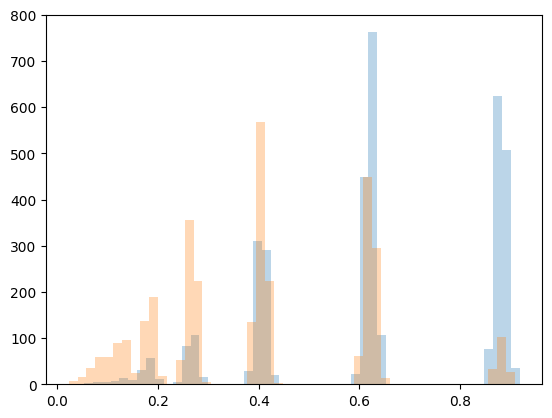

In [32]:
plt.hist(treated_ps, density=False, bins=50, alpha=0.3)
plt.hist(control_ps, density=False, bins=50, alpha=0.3)

In [34]:
SinusitisPatientRecord.save_record("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/")

In [35]:
SinusitisPatientRecord.save_record_nfold("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/")

In [36]:
SinusitisPatientRecord.save_params("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/")

In [37]:
SinusitisPatientRecord.rebuild_code_dict("C:/Users/jayao/Desktop/python_projects/transformer_propensity/data/synthea/")